In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import intake
import s3fs
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point
import scipy.stats as stats

ERROR 1: PROJ: proj_create_from_database: Open of /opt/anaconda3/envs/eds296-stevenson/share/proj failed


## Area of Interest

I chose Greenland as my area of interest for this project. The main reason I chose this area is because it is in the Arctic. I also chose precipitation as my variable. The reason I wanted to look at precipitation is because it is so uncommon in the Arctic. As climate change accelerates, it can cause unexpected changes to the weather, and one of those is more precipitation in more northern regions. Currently, Greenlands has an Arctic tundra climate along the coasts and an ice-cap climate in the inland area. Approximately 80% of Greenland's land is covered by an ice sheet. The southern coastal areas can be impacted by gulf streams bringing warmer air to the region, which is another reason why I thought it would be interesting to look at precipitation.

## Models used

For this project, I used the same models I did in my last project (The Canadian Earth System Model Version 5, and The Community Earth System Model Version 2). In my previous project, there was a noticeable difference between the model predictions of air temperature, so I wanted to see if that would apply here. I chose a ssp585 experiment, as I am not optimistic. For the dates, I chose 1950-1980 and 2050-2080. The dates seem near enough to be able to highlight how much can change in a short amount of time.  

### Maping area of interest

In [2]:
# Define area of interest
lat_min, lat_max = 55.0, 90.0 
lon_min, lon_max = 285.0,350.0 

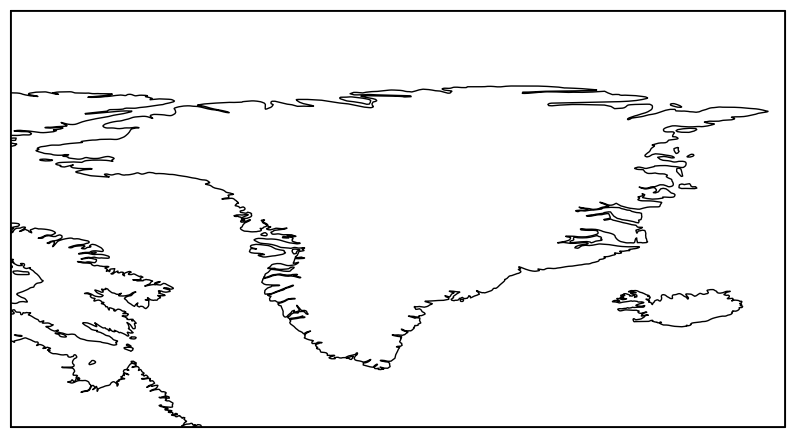

In [3]:
# Create plot to ensure the coordinates are where I want 
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180)) 

# Add features
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS)

# Add the bounding box
ax.plot([lon_min, lon_max, lon_max, lon_min, lon_min],
        [lat_min, lat_min, lat_max, lat_max, lat_min],
        transform=ccrs.PlateCarree(),
        color='Black', linewidth=2)

## Loading the model

In [4]:
# Load CMIP6 Catalog
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')
# Specify search terms to query catalog 
# activity_id: which project do you want? CMIP = historical
activity_ids = ['ScenarioMIP', 'CMIP']

# Experiments: historical, SSP3-7.0, SSP5-8.5
experiment_ids = ['historical', 'ssp585']

# Ensemble member: r10i1p1f1
member_id = 'r10i1p1f1'

# Data type: monthly atmospheric output
table_id = 'Amon'

# Variable_id: Precipitation  
variable_id = 'pr'

# Search through catalog, store results in "res" variable
CanESM5  = catalog.search(activity_id=activity_ids, 
                     source_id='CanESM5',
                     experiment_id=experiment_ids,
                     table_id=table_id,
                     variable_id=variable_id)

CanESM5  = CanESM5 .df
CanESM5 

activity_id institution_id source_id experiment_id  member_id table_id  \
0           CMIP          CCCma   CanESM5    historical  r11i1p2f1     Amon   
1    ScenarioMIP          CCCma   CanESM5        ssp585  r22i1p1f1     Amon   
2    ScenarioMIP          CCCma   CanESM5        ssp585  r21i1p2f1     Amon   
3    ScenarioMIP          CCCma   CanESM5        ssp585  r21i1p1f1     Amon   
4           CMIP          CCCma   CanESM5    historical  r10i1p1f1     Amon   
..           ...            ...       ...           ...        ...      ...   
110         CMIP          CCCma   CanESM5    historical  r15i1p2f1     Amon   
111         CMIP          CCCma   CanESM5    historical  r16i1p1f1     Amon   
112         CMIP          CCCma   CanESM5    historical  r16i1p2f1     Amon   
113         CMIP          CCCma   CanESM5    historical  r20i1p1f1     Amon   
114         CMIP          CCCma   CanESM5    historical  r20i1p2f1     Amon   

    variable_id grid_label                                             zstore  \
0            pr         gn  s3://cmip6-pds/CMIP6/CMIP/CCCma/CanESM5/histor...   
1            pr         gn  s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...   
2            pr         gn  s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...   
3            pr         gn  s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...   
4            pr         gn  s3://cmip6-pds/CMIP6/CMIP/CCCma/CanESM5/histor...   
..          ...        ...                                                ...   
110          pr         gn  s3://cmip6-pds/CMIP6/CMIP/CCCma/CanESM5/histor...   
111          pr         gn  s3://cmip6-pds/CMIP6/CMIP/CCCma/CanESM5/histor...   
112          pr         gn  s3://cmip6-pds/CMIP6/CMIP/CCCma/CanESM5/histor...   
113          pr         gn  s3://cmip6-pds/CMIP6/CMIP/CCCma/CanESM5/histor...   
114          pr         gn  s3://cmip6-pds/CMIP6/CMIP/CCCma/CanESM5/histor...   

     dcpp_init_year   version  
0               NaN  20190429  
1               NaN  20190429  
2               NaN  20190429  
3               NaN  20190429  
4               NaN  20190429  
..              ...       ...  
110             NaN  20190429  
111             NaN  20190429  
112             NaN  20190429  
113             NaN  20190429  
114             NaN  20190429  

[115 rows x 11 columns]

In [5]:
# Saving models
hist_CanESM5 = xr.open_zarr(CanESM5.iloc[0]['zstore'], storage_options={'anon': True}, consolidated=True)
fut_CanESM5 = xr.open_zarr(CanESM5.iloc[1]['zstore'], storage_options={'anon': True}, consolidated=True)

In [6]:
# Search through catalog
CESM2 = catalog.search(activity_id=activity_ids, 
                     source_id='CESM2',
                     experiment_id= experiment_ids,
                     table_id=table_id,
                     #member_id=member_id,
                     variable_id=variable_id)

CESM2 = CESM2.df
CESM2

activity_id institution_id source_id experiment_id  member_id table_id  \
0          CMIP           NCAR     CESM2    historical   r5i1p1f1     Amon   
1          CMIP           NCAR     CESM2    historical   r1i1p1f1     Amon   
2          CMIP           NCAR     CESM2    historical   r8i1p1f1     Amon   
3          CMIP           NCAR     CESM2    historical   r4i1p1f1     Amon   
4          CMIP           NCAR     CESM2    historical   r2i1p1f1     Amon   
5          CMIP           NCAR     CESM2    historical   r3i1p1f1     Amon   
6          CMIP           NCAR     CESM2    historical   r7i1p1f1     Amon   
7          CMIP           NCAR     CESM2    historical   r6i1p1f1     Amon   
8          CMIP           NCAR     CESM2    historical  r11i1p1f1     Amon   
9          CMIP           NCAR     CESM2    historical  r10i1p1f1     Amon   
10         CMIP           NCAR     CESM2    historical   r9i1p1f1     Amon   
11  ScenarioMIP           NCAR     CESM2        ssp585   r4i1p1f1     Amon   
12  ScenarioMIP           NCAR     CESM2        ssp585  r11i1p1f1     Amon   
13  ScenarioMIP           NCAR     CESM2        ssp585  r10i1p1f1     Amon   

   variable_id grid_label                                             zstore  \
0           pr         gn  s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...   
1           pr         gn  s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...   
2           pr         gn  s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...   
3           pr         gn  s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...   
4           pr         gn  s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...   
5           pr         gn  s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...   
6           pr         gn  s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...   
7           pr         gn  s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...   
8           pr         gn  s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...   
9           pr         gn  s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...   
10          pr         gn  s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...   
11          pr         gn  s3://cmip6-pds/CMIP6/ScenarioMIP/NCAR/CESM2/ss...   
12          pr         gn  s3://cmip6-pds/CMIP6/ScenarioMIP/NCAR/CESM2/ss...   
13          pr         gn  s3://cmip6-pds/CMIP6/ScenarioMIP/NCAR/CESM2/ss...   

    dcpp_init_year   version  
0              NaN  20190401  
1              NaN  20190401  
2              NaN  20190401  
3              NaN  20190401  
4              NaN  20190401  
5              NaN  20190401  
6              NaN  20190401  
7              NaN  20190401  
8              NaN  20190514  
9              NaN  20200124  
10             NaN  20200124  
11             NaN  20200528  
12             NaN  20200528  
13             NaN  20200528

## Formatting the models

In [7]:
# Saving models
hist_CESM2 = xr.open_zarr(CESM2.iloc[0]['zstore'], storage_options={'anon': True}, consolidated=True)
fut_CESM2 = xr.open_zarr(CESM2.iloc[11]['zstore'], storage_options={'anon': True}, consolidated=True)

In [8]:
# Ensure the date time variable is formatted
hist_CanESM5['time'] = hist_CanESM5.time.astype('datetime64[ns]')
fut_CanESM5['time'] = fut_CanESM5.time.astype('datetime64[ns]')
hist_CESM2['time'] = hist_CESM2.time.astype('datetime64[ns]')
fut_CESM2['time'] = fut_CESM2.time.astype('datetime64[ns]')

In [9]:
cesm_data = xr.concat([hist_CESM2, fut_CESM2], dim="time")
canesm_data = xr.concat([hist_CanESM5, fut_CanESM5], dim="time")

In [11]:
# Focus on the right place
cesm_data_lat = (cesm_data.lat >= lat_min) & (cesm_data.lat <= lat_max)
cesm_data_lon = (cesm_data.lon >= lon_min) & (cesm_data.lon <= lon_max)

canesm_data_lat = (canesm_data.lat >= lat_min) & (canesm_data.lat <= lat_max)
canesm_data_lon = (canesm_data.lon >= lon_min) & (canesm_data.lon <= lon_max)

In [12]:
# Find points where the mask value is True, drop all other points
cesm_pr = cesm_data.where(cesm_data_lat & cesm_data_lon, drop=True)
canesm_pr = canesm_data.where(canesm_data_lat & canesm_data_lon, drop=True)

In [13]:
# Choosing dates
cesm_pr_hist_mask = (cesm_pr.time.dt.year >= 1950) & (cesm_pr.time.dt.year <= 1980)
cesm_pr_proj_mask = (cesm_pr.time.dt.year >= 2050) & (cesm_pr.time.dt.year <= 2080)
canesm_pr_hist_mask = (canesm_pr.time.dt.year >= 1950) & (canesm_pr.time.dt.year <= 1980)
canesm_pr_proj_mask = (canesm_pr.time.dt.year >= 2050) & (canesm_pr.time.dt.year <= 2080)

In [14]:
# Select data for historical (1950-1980) and projected (2050-2080) time periods
# from both CESM and CanESM models using the previously defined time masks
cesm_pr_hist = cesm_pr.sel(time=cesm_pr_hist_mask)
cesm_pr_proj = cesm_pr.sel(time=cesm_pr_proj_mask)
canesm_pr_hist = canesm_pr.sel(time=canesm_pr_hist_mask)
canesm_pr_proj = canesm_pr.sel(time=canesm_pr_proj_mask)

In [15]:
# Convert precipitation units from kg/m²/s to mm/day
cesm_pr_hist['pr'] = cesm_pr_hist['pr'] * 86400
cesm_pr_proj['pr'] = cesm_pr_proj['pr'] * 86400
canesm_pr_hist['pr'] = canesm_pr_hist['pr'] * 86400
canesm_pr_proj['pr'] = canesm_pr_proj['pr'] * 86400


In [16]:
# Calculate mean precipitation by averaging across time dimensions
cesm_pr_hist_mean = cesm_pr_hist.mean(dim="time")
cesm_pr_proj_mean = cesm_pr_proj.mean(dim="time")
canesm_pr_hist_mean = canesm_pr_hist.mean(dim="time")
canesm_pr_proj_mean = canesm_pr_proj.mean(dim="time")

## Mapping the models

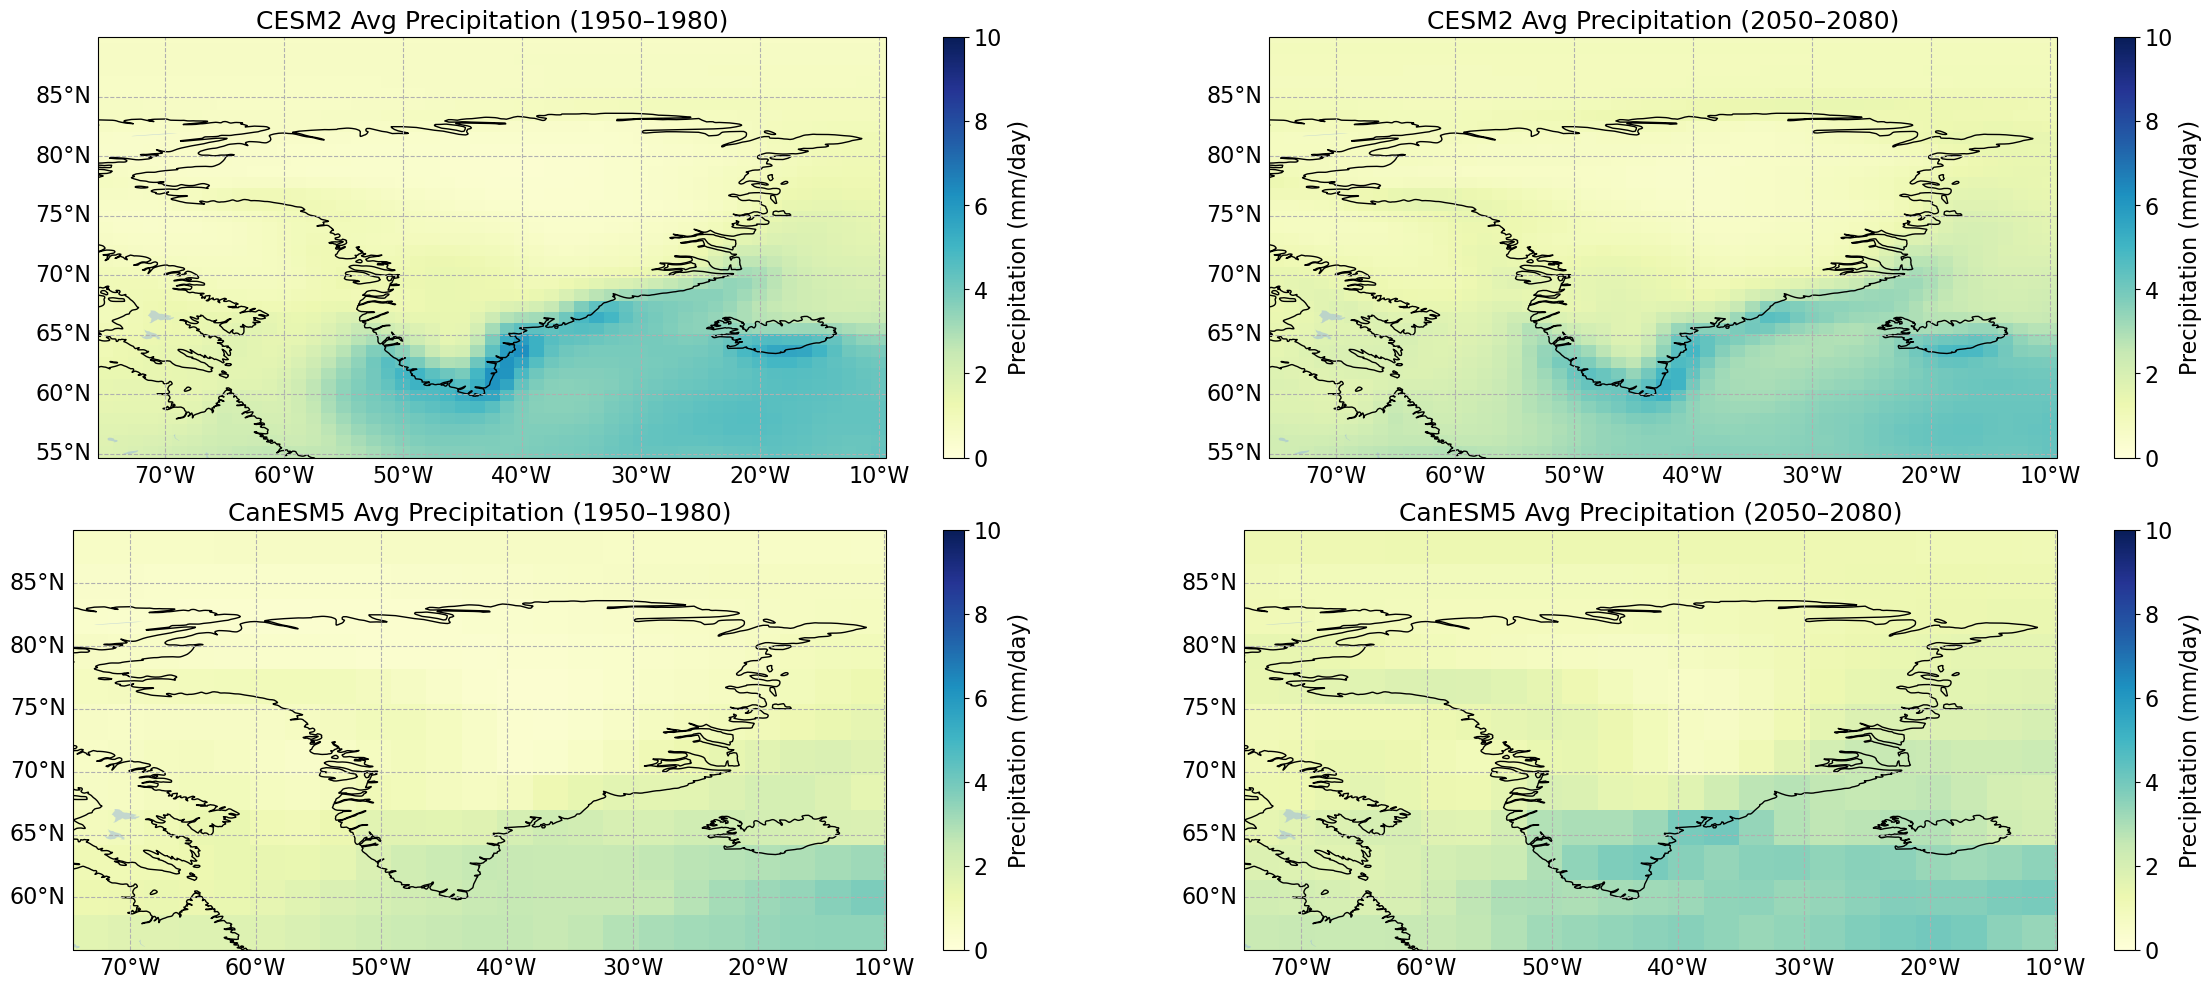

In [29]:
map = ccrs.PlateCarree()

# Create a figure with 4 subplots (2 rows, 2 columns)
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(24, 10), subplot_kw={"projection": map})

# === Subplot 1: CESM2 Historical ===
plot1 = axes[0, 0].pcolormesh(
    cesm_pr_hist_mean_mm.lon,
    cesm_pr_hist_mean_mm.lat,
    cesm_pr_hist_mean_mm.values,
    transform=map, cmap="YlGnBu", vmin=0, vmax=10
)

axes[0, 0].add_feature(cfeature.COASTLINE)
axes[0, 0].add_feature(cfeature.LAKES, alpha=0.5)
axes[0, 0].add_feature(cfeature.RIVERS, alpha=0.5)

gl1 = axes[0, 0].gridlines(draw_labels=True, linestyle="--")
gl1.top_labels = False
gl1.right_labels = False
gl1.xlabel_style = {'size': 16}
gl1.ylabel_style = {'size': 16}
cbar1 = plt.colorbar(plot1, ax=axes[0, 0], orientation='vertical', pad=0.05)
cbar1.set_label("Precipitation (mm/day)", fontsize=16)
cbar1.ax.tick_params(labelsize=16)
axes[0, 0].set_title("CESM2 Avg Precipitation (1950–1980)", fontsize=18)

# === Subplot 2: CESM2 Projected ===
plot2 = axes[0, 1].pcolormesh(
    cesm_pr_proj_mean_mm.lon,
    cesm_pr_proj_mean_mm.lat,
    cesm_pr_proj_mean_mm.values,
    transform=map, cmap="YlGnBu", vmin=0, vmax=10
)

axes[0, 1].add_feature(cfeature.COASTLINE)
axes[0, 1].add_feature(cfeature.LAKES, alpha=0.5)
axes[0, 1].add_feature(cfeature.RIVERS, alpha=0.5)
gl2 = axes[0, 1].gridlines(draw_labels=True, linestyle="--")
gl2.top_labels = False
gl2.right_labels = False
gl2.xlabel_style = {'size': 16}
gl2.ylabel_style = {'size': 16}
cbar2 = plt.colorbar(plot2, ax=axes[0, 1], orientation='vertical', pad=0.05)
cbar2.set_label("Precipitation (mm/day)", fontsize=16)
cbar2.ax.tick_params(labelsize=16)
axes[0, 1].set_title("CESM2 Avg Precipitation (2050–2080)", fontsize=18)

# === Subplot 3: CanESM5 Historical ===
plot3 = axes[1, 0].pcolormesh(
    canesm_pr_hist_mean_mm.lon,
    canesm_pr_hist_mean_mm.lat,
    canesm_pr_hist_mean_mm.values,
    transform=map, cmap="YlGnBu", vmin=0, vmax=10
)

axes[1, 0].add_feature(cfeature.COASTLINE)
axes[1, 0].add_feature(cfeature.LAKES, alpha=0.5)
axes[1, 0].add_feature(cfeature.RIVERS, alpha=0.5)
gl3 = axes[1, 0].gridlines(draw_labels=True, linestyle="--")
gl3.top_labels = False
gl3.right_labels = False
gl3.xlabel_style = {'size': 16}
gl3.ylabel_style = {'size': 16}
cbar3 = plt.colorbar(plot3, ax=axes[1, 0], orientation='vertical', pad=0.05)
cbar3.set_label("Precipitation (mm/day)", fontsize=16)
cbar3.ax.tick_params(labelsize=16)
axes[1, 0].set_title("CanESM5 Avg Precipitation (1950–1980)", fontsize=18)

# === Subplot 4: CanESM5 Projected ===
plot4 = axes[1, 1].pcolormesh(
    canesm_pr_proj_mean_mm.lon,
    canesm_pr_proj_mean_mm.lat,
    canesm_pr_proj_mean_mm.values,
    transform=map, cmap="YlGnBu", vmin=0, vmax=10
)

axes[1, 1].add_feature(cfeature.COASTLINE)
axes[1, 1].add_feature(cfeature.LAKES, alpha=0.5)
axes[1, 1].add_feature(cfeature.RIVERS, alpha=0.5)

gl4 = axes[1, 1].gridlines(draw_labels=True, linestyle="--")
gl4.top_labels = False
gl4.right_labels = False
gl4.xlabel_style = {'size': 16}
gl4.ylabel_style = {'size': 16}
cbar4 = plt.colorbar(plot4, ax=axes[1, 1], orientation='vertical', pad=0.05)
cbar4.set_label("Precipitation (mm/day)", fontsize=16)
cbar4.ax.tick_params(labelsize=16)
axes[1, 1].set_title("CanESM5 Avg Precipitation (2050–2080)", fontsize=18)

plt.tight_layout()
plt.show()


## First maps comparison

The maps show that the models have very different forcasts for future precipitation. The CESM2 future prediction appears to show less precipiptation in the future, whereas the CanESM5 seems to predict more. Interestingly, the models maps of the past are very different as well, with the CESM2 showing much more precipitation than the CanESM5. 

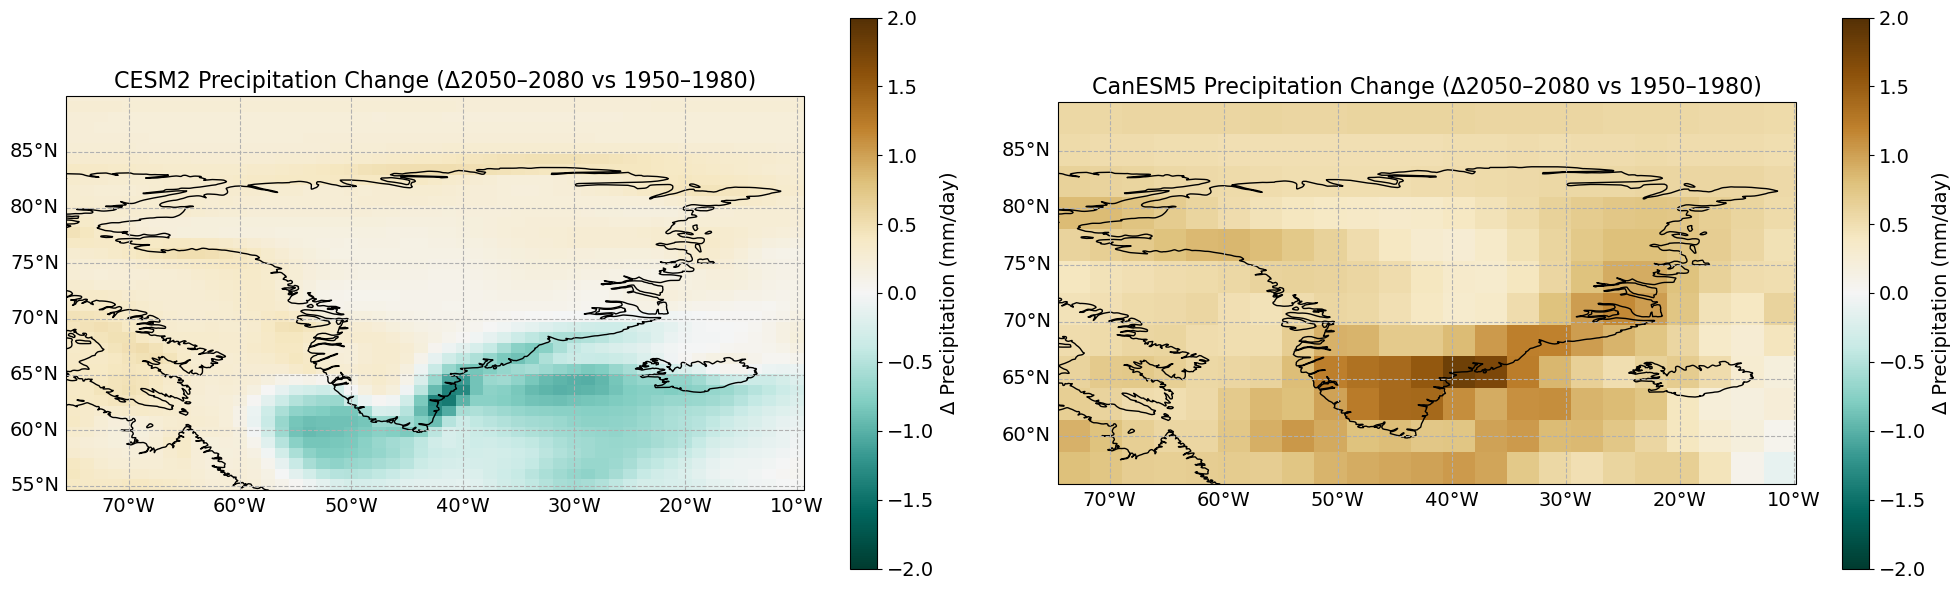

In [31]:
map = ccrs.PlateCarree()

# Create a figure with 1 row, 2 columns
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 6), subplot_kw={"projection": map})

# === Subplot 1: CESM2 Change ===
plot1 = axes[0].pcolormesh(
    cesm_pr_change.lon,
    cesm_pr_change.lat,
    cesm_pr_change.values,
    transform=map, cmap="BrBG_r", vmin=-2, vmax=2
)

axes[0].add_feature(cfeature.COASTLINE)
gl1 = axes[0].gridlines(draw_labels=True, linestyle="--")
gl1.top_labels = False
gl1.right_labels = False
gl1.xlabel_style = {'size': 14}
gl1.ylabel_style = {'size': 14}
cbar1 = plt.colorbar(plot1, ax=axes[0], orientation='vertical', pad=0.05)
cbar1.set_label("Δ Precipitation (mm/day)", fontsize=14)
cbar1.ax.tick_params(labelsize=14)
axes[0].set_title("CESM2 Precipitation Change (Δ2050–2080 vs 1950–1980)", fontsize=16)

# === Subplot 2: CanESM5 Change ===
plot2 = axes[1].pcolormesh(
    canesm_pr_change.lon,
    canesm_pr_change.lat,
    canesm_pr_change.values,
    transform=map, cmap="BrBG_r", vmin=-2, vmax=2
)

axes[1].add_feature(cfeature.COASTLINE)
gl2 = axes[1].gridlines(draw_labels=True, linestyle="--")
gl2.top_labels = False
gl2.right_labels = False
gl2.xlabel_style = {'size': 14}
gl2.ylabel_style = {'size': 14}
cbar2 = plt.colorbar(plot2, ax=axes[1], orientation='vertical', pad=0.05)
cbar2.set_label("Δ Precipitation (mm/day)", fontsize=14)
cbar2.ax.tick_params(labelsize=14)
axes[1].set_title("CanESM5 Precipitation Change (Δ2050–2080 vs 1950–1980)", fontsize=16)

plt.tight_layout()
plt.show()


## Results of different maps

As would be expected by looking at the first four maps, the models show very different outcomes. The color differences, as well as the resolution differences, are very striking. CanESM5 shows a change towards more precipitation whereas the CESM2 shows the opposite. While I expected to see more change along the southern coast, as that is where the Gulf Stream is, I did not expect the models to show such different results. I have found this so surprising that I keep going back and double-checking to see if I got any of the code backward. 

I have come to the conclusion that the area probably reveives so little rain that even the slightlest amount of change would be highlighted by these maps. The very most amount of change the models predict is a +2 or -2 mm per day. 
Ultimately, the two models disagree about the impact of a severe climate scenario on precipitation in Greenland. 